# CENG403 - Spring 2024 - THE3

# Task 2: CNN with PyTorch
In this task, you will implement a convolutional neural network (CNN) with PyTorch.


## 2.1 Import the Modules

Let us start with importing some libraries that we will use throughout the task.

In [1]:
# PyTorch libraries:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import random
# install and import the torchinfo library
!pip install torchinfo
from torchinfo import summary

## 2.2 Enable GPU

First, under "Edit -> Notebook Settings -> Hardware accelerator", select a GPU. With the following, we will inform PyTorch that we want to use the GPU.

In [2]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


## 2.3 The Dataset

We will use torchvision.datasets to download the CIFAR10 dataset.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 101410465.24it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 2.3.1 Visualize Samples

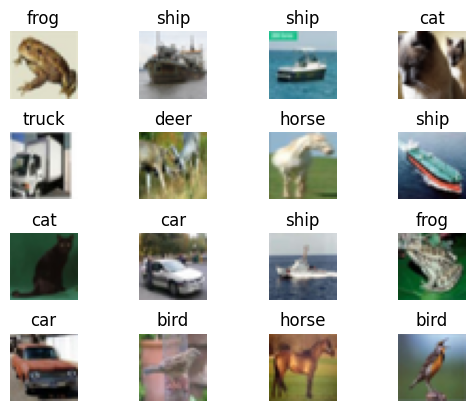

In [4]:
dataiter = iter(trainloader)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
S = 4

for i in range(S):
  for j in range(S):
    images, labels = next(dataiter)
    X = np.transpose(images[0].numpy()/2+0.5, (1, 2, 0))
    y = labels[0]

    plt.subplot(S, S, i*S+j+1)
    plt.imshow(X)
    plt.axis('off')
    plt.title(classes[y])
    plt.subplots_adjust(hspace = 0.5)

plt.show()

## 2.4 Define and Train a Small CNN Model

Now, all the pieces are ready and we can define a model.

### 2.4.1 Model Definition

Create a three-layer CNN with the following layers:

| Layer Name | Input HxW | Filter size | Stride | Pad | # of in channels | Out HxW | # of out channels |
| ----| -----| ----| ---| ---| ----| -----|---------- |
| Conv1   | 32x32 | ? | ? | ? | 3  | 28x28 | 16 |
| Conv2   | 28x28 | ? | ? | ? | 16 | 26x26 | 32 |
| Maxpool | 26x26 | 4 | 2 | 0 | 32 | 12x12 | 32 |
| Conv3   | 12x12 | ? | ? | ? | 32 | 10x10 | 32 |

and the fully-connected layers:

| Layer Name | Input Size | Output size |
| ----| -----| ----|
| FC1 | 3200 | 1500 |
| FC2 | 1500 | 10 |

You should choose suitable values for variables marked with `?' in the table and make sure that receptive fields can be properly placed in all layers.

While creating your model, pay attention to the following aspects:
* Each Conv layer and FC layer will be followed by ReLU, except for the last one.
* You should keep all other parameters (dilation, bias, group-mode, ..) as their default values in Pytorch.

You will need to read the following pages from Pytorch regarding the layers that you will use:
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
* [MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html?highlight=maxpool#torch.nn.MaxPool2d)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SmallCNN(nn.Module):
    def __init__(self):
        super(SmallCNN, self).__init__()
        torch.manual_seed(403)
        random.seed(403)
        np.random.seed(403)


        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)

        self.maxpool = nn.MaxPool2d(kernel_size=4, stride=2)

        self.fc1 = nn.Linear(3200, 1500)
        self.fc2 = nn.Linear(1500, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.maxpool(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0),-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### 2.4.2 Trainer for the Model

Let us define our training function, which will use the cuda device for training the model.

In [6]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):
    """
    Define the trainer function. We can use this for training any model.
    The parameter names are self-explanatory.

    Returns: the loss history.
    """
    loss_history = []
    for epoch in range(epochs):
        epoch_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            # Our batch:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the gradients as PyTorch accumulates them
            optimizer.zero_grad()

            # Obtain the scores
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Backpropagate
            loss.backward()

            # Update the weights
            optimizer.step()

            # Record the loss
            epoch_loss += loss.item()

        # Calculate average loss for the epoch
        avg_epoch_loss = epoch_loss / len(dataloader)

        # Append the average epoch loss to loss history
        loss_history.append(avg_epoch_loss)

        if verbose:
            print(f'Epoch {epoch + 1} / {epochs}, Avg. Loss: {avg_epoch_loss}')

    return loss_history


### 2.4.3 Create and visualize the model

In [7]:
model = SmallCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
SmallCNN                                 [128, 10]                 --
├─Conv2d: 1-1                            [128, 16, 28, 28]         1,216
├─Conv2d: 1-2                            [128, 32, 26, 26]         12,832
├─MaxPool2d: 1-3                         [128, 32, 12, 12]         --
├─Conv2d: 1-4                            [128, 32, 10, 10]         9,248
├─Linear: 1-5                            [128, 1500]               4,801,500
├─Linear: 1-6                            [128, 10]                 15,010
Total params: 4,839,806
Trainable params: 4,839,806
Non-trainable params: 0
Total mult-adds (G): 1.97
Input size (MB): 1.57
Forward/backward pass size (MB): 39.82
Params size (MB): 19.36
Estimated Total Size (MB): 60.75

### 2.4.4 Train the Small Model

We will create an instance of our model and "define" which loss function we want to use. We will also state our choice for the optimizer here.

For more information, check the PyTorch docs: [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) and [SGD](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD).

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

Epoch 1 / 10, Avg. Loss: 2.255732747295019
Epoch 2 / 10, Avg. Loss: 1.9569161401685242
Epoch 3 / 10, Avg. Loss: 1.7289911237214228
Epoch 4 / 10, Avg. Loss: 1.599656401997637
Epoch 5 / 10, Avg. Loss: 1.507466468054925
Epoch 6 / 10, Avg. Loss: 1.4271345726974176
Epoch 7 / 10, Avg. Loss: 1.3744977310185542
Epoch 8 / 10, Avg. Loss: 1.3165002518602649
Epoch 9 / 10, Avg. Loss: 1.2601329277238578
Epoch 10 / 10, Avg. Loss: 1.2127816222817696


### 2.4.5 The Loss Curve

Let us visualize the loss curve.

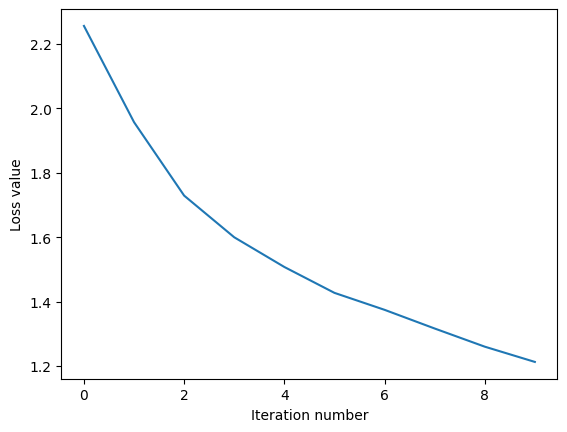

In [9]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.4.6 Quantitative Analysis

We can analyze the accuracy of the predictions as follows. You should see around 54\% accuracies. We can finetune the hyperparameters to obtain better results. But we will skip that and go for a bigger model.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [10]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 56 %


## 2.5 Your CNN

Now, create your own CNN. It should have at least 5 convolutional layers. Other than that, there is no restriction on what you can use in your CNN or how you can structure it.


### 2.5.1 Model Definition

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class YourCNN(nn.Module):
    def __init__(self):
        super(YourCNN, self).__init__()
        torch.manual_seed(16)


        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=7, stride=1, padding=1)  # 32 -28
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=0) # 28 -24
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=75, kernel_size=5, stride=1, padding=0) # 24 -20
        self.conv4 = nn.Conv2d(in_channels=75, out_channels=90, kernel_size=4, stride=1, padding=0) #20 -17
        self.conv5 = nn.Conv2d(in_channels=90, out_channels=100, kernel_size=3, stride=1, padding=0) #17 - 14


        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)  # (14x14) -> (7x7)


        self.fc1 = nn.Linear(100 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.maxpool(x)


        x = x.view(-1, 100 * 7 * 7)


        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


### 2.5.2 Create and visuale your model

In [12]:
model = YourCNN()

summary(model, input_size=(batch_size, 3, 32, 32))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
YourCNN                                  [128, 10]                 --
├─Conv2d: 1-1                            [128, 32, 28, 28]         4,736
├─Conv2d: 1-2                            [128, 64, 24, 24]         51,264
├─Conv2d: 1-3                            [128, 75, 20, 20]         120,075
├─Conv2d: 1-4                            [128, 90, 17, 17]         108,090
├─Conv2d: 1-5                            [128, 100, 15, 15]        81,100
├─MaxPool2d: 1-6                         [128, 100, 7, 7]          --
├─Linear: 1-7                            [128, 64]                 313,664
├─Linear: 1-8                            [128, 32]                 2,080
├─Linear: 1-9                            [128, 10]                 330
Total params: 681,339
Trainable params: 681,339
Non-trainable params: 0
Total mult-adds (G): 16.78
Input size (MB): 1.57
Forward/backward pass size (MB): 143.94
Params size (MB): 2.73
Estimated T

### 2.5.3 Train the Model

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0025, momentum=0.9)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
model = model.to(device)
epochs = 10
loss_history = train(model, criterion, optimizer, epochs, trainloader)

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 / 10, Avg. Loss: 2.3036856425692664
Epoch 2 / 10, Avg. Loss: 2.3015798723606196
Epoch 3 / 10, Avg. Loss: 2.1895270417718327
Epoch 4 / 10, Avg. Loss: 1.8569002267344834
Epoch 5 / 10, Avg. Loss: 1.707449278868068
Epoch 6 / 10, Avg. Loss: 1.6375160397166182
Epoch 7 / 10, Avg. Loss: 1.5573638055635535
Epoch 8 / 10, Avg. Loss: 1.5127430648145164
Epoch 9 / 10, Avg. Loss: 1.461422454670567
Epoch 10 / 10, Avg. Loss: 1.414848097449983


### 2.5.4 Loss Curve

Let us visualize the loss curve.

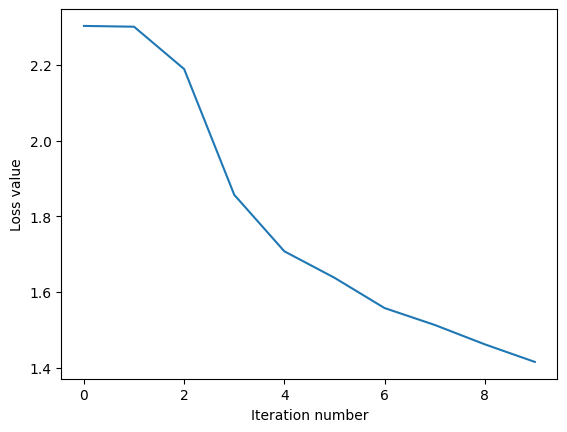

In [14]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 2.5.5 Quantitative Analysis

Analyze your model quantitatively.

*Disclaimer: This code piece is taken from PyTorch examples.*

In [15]:
correct = 0
total = 0
model = model.to("cpu")
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 48 %
